In [63]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter
from scipy.fftpack import fft
%matplotlib inline

In [64]:
#read csv file and return its data-frame
def read_csv_file(acc, gyro, mode):
    df_gyro = pd.read_csv(gyro)
    df      = pd.read_csv(acc)
    df.rename(columns = {'X': 'AX', 'Y':'AY', 'Z':'AZ'}, inplace = True)
    df['GX'] = df_gyro['X']
    df['GY'] = df_gyro['Y']
    df['GZ'] = df_gyro['Z']
    
    df['activity'] = mode
    
    return df



In [65]:
#data for bike
acc_file = 'data/Bike2308/2018-08-23_16-18-07/AccelerometerLinear.csv'
gyro_file= 'data/Bike2308/2018-08-23_16-18-07/Gyroscope.csv'

df_bike = read_csv_file(acc_file, gyro_file, 'bike')
print("shape -", df_bike.shape)
df_bike = df_bike[3000:13000]
print("shape -", df_bike.shape)
df_bike.head()

shape - (14413, 8)
shape - (10000, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
3000,60002,0.946191,0.335965,-1.380772,-0.063095,-0.078720,0.035873,bike
3001,60021,0.282677,0.677211,-0.592512,-0.114227,-0.141571,0.008179,bike
3002,60041,0.541477,0.866996,1.060262,-0.052444,-0.141571,-0.037628,bike
3003,60061,0.069439,0.456029,0.068076,0.149963,0.006500,-0.031235,bike
3004,60082,0.005020,-0.462948,-1.091515,0.076462,-0.005219,-0.020584,bike


In [66]:
#data for car

acc_file = 'data/car/2018-08-17_16-43-04/AccelerometerLinear.csv'
gyro_file= 'data/car/2018-08-17_16-43-04/Gyroscope.csv'

df_car = read_csv_file(acc_file, gyro_file, 'car')
print("shape -", df_car.shape)
df_car = df_car[1300:12000]
print("shape -", df_car.shape)
df_car.head()

shape - (6646, 8)
shape - (5346, 8)


,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity
1300,26000,1.310577,-0.599656,-2.653413,-0.030792,-0.118576,-0.002655,car
1301,26020,0.001736,-1.469157,2.047003,-0.094711,0.188217,0.012268,car
1302,26041,-0.361463,-0.839294,0.419466,0.088516,0.030563,0.010132,car
1303,26061,1.720914,-0.621697,0.038787,-0.090454,-0.015244,-0.003723,car
1304,26080,2.569507,-1.287929,-0.327906,-0.049973,-0.208054,-0.003723,car


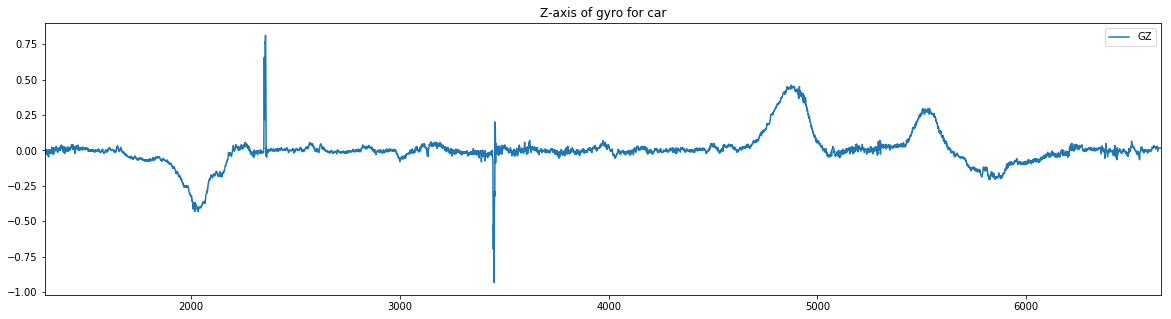

In [67]:
df_car[['GZ']].plot(figsize =(20,5), title = 'Z-axis of gyro for car')

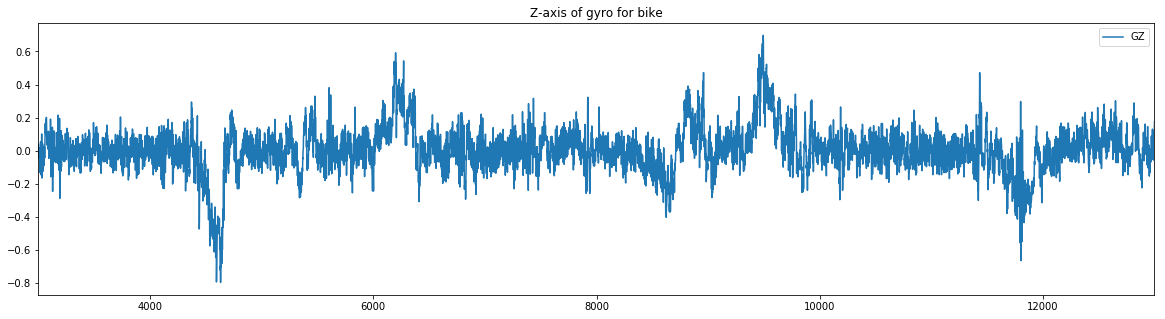

In [68]:
df_bike[['GZ']].plot(figsize =(20,5), title = 'Z-axis of gyro for bike')

In [69]:
def GaussianFilter(df, window_length):
    df1 = df
    df1['AX'] = gaussian_filter(df['AX'], window_length)
    df1['AY'] = gaussian_filter(df['AY'], window_length)
    df1['AZ'] = gaussian_filter(df['AZ'], window_length)

    df1['GX'] = gaussian_filter(df['GX'], window_length)
    df1['GY'] = gaussian_filter(df['GY'], window_length)
    df1['GZ'] = gaussian_filter(df['GZ'], window_length)
    
    return df1


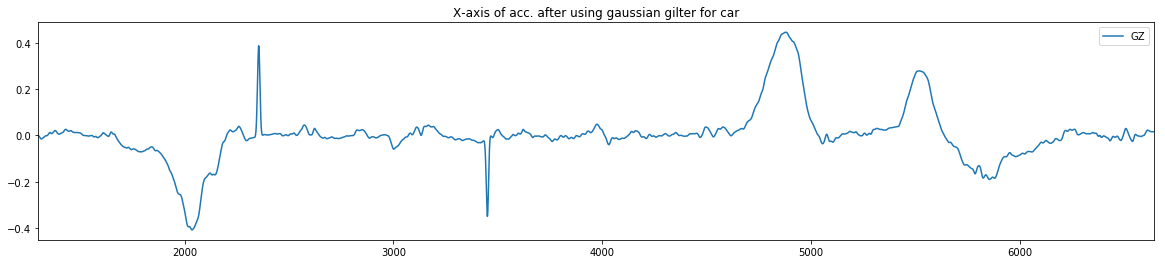

In [70]:
df_car_smooth = GaussianFilter(df_car, 5)
df_car_smooth[['GZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for car")


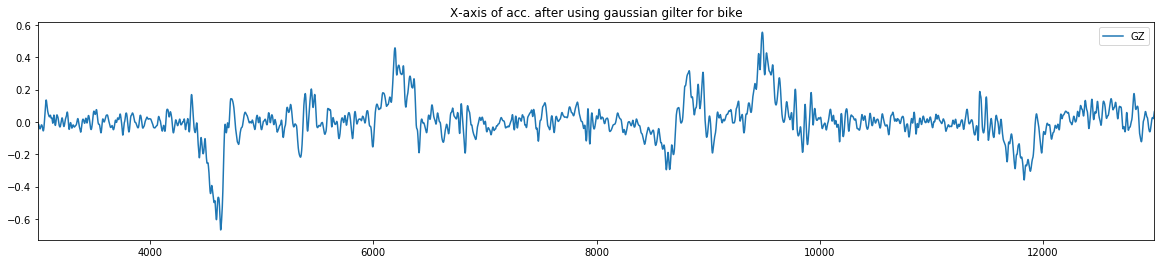

In [71]:
df_bike_smooth = GaussianFilter(df_bike, 5)
df_bike_smooth[['GZ']].plot(figsize = (20,4), title = "X-axis of acc. after using gaussian gilter for bike")

In [72]:
#generate frequency domain data from time domain data usinf Fast Fourier transformation
def FFT(df, features):
    fftfeatures = []
    
    for i in features:
        reals = np.real(np.fft.rfft(df[i]))
        imagn = np.imag(np.fft.rfft(df[i]))

        complexs = [reals[0]]
        n = len(reals)
        if(n%2 == 0):
            complexs.append(imagn[0])
        for j in range(1, n-1):
            complexs.append(reals[j])
            complexs.append(imagn[j])
#         complexs.append(reals[j])
        if( len(df) > len(complexs)):
            complexs.append(imagn[j])
        df['f'+i] = complexs
        fftfeatures.append('f'+i)
    return df

In [73]:
features = ['AX', 'AY', 'AZ', 'GX', 'GY', 'GZ']
df_freq_car = FFT(df_car, features)
df_freq_bike = FFT(df_bike, features)
df_freq_bike.head()

,Milliseconds,AX,AY,AZ,GX,GY,GZ,activity,fAX,fAY,fAZ,fGX,fGY,fGZ
3000,60002,0.389429,0.270027,-0.179242,-0.004421,-0.066611,-0.014123,bike,-619.431623,-1116.646935,54.393348,-58.661314,46.307175,42.153945
3001,60021,0.383271,0.258645,-0.167288,-0.003469,-0.065612,-0.014847,bike,-37.506253,13.900211,39.896825,-2.320356,-18.027805,-143.331798
3002,60041,0.371673,0.237095,-0.144573,-0.001742,-0.063729,-0.016242,bike,68.355926,20.390148,-16.426576,2.068265,-0.238203,42.262493
3003,60061,0.356164,0.207692,-0.113133,0.000447,-0.061182,-0.018218,bike,155.575573,253.675925,-49.040567,10.026813,-9.467926,-24.100016
3004,60082,0.338680,0.173478,-0.075654,0.002709,-0.058244,-0.020660,bike,223.624462,108.406066,22.834496,16.566184,-12.123437,-13.090061


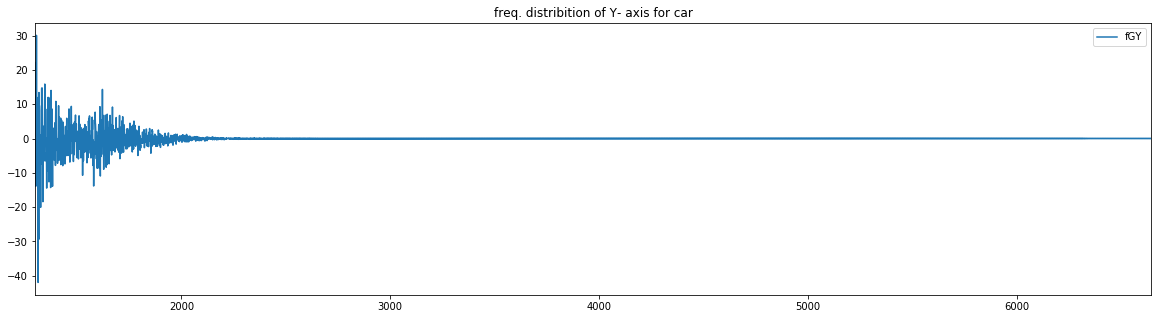

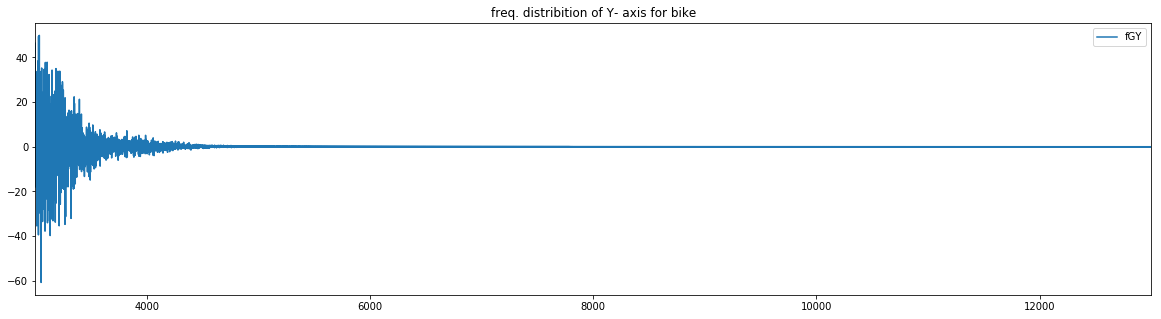

In [74]:
df_freq_car[['fGY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis for car")
df_freq_bike[['fGY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis for bike")

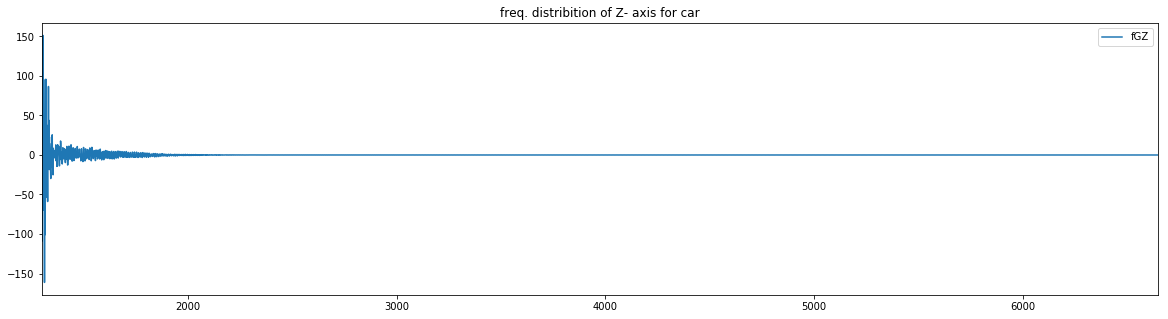

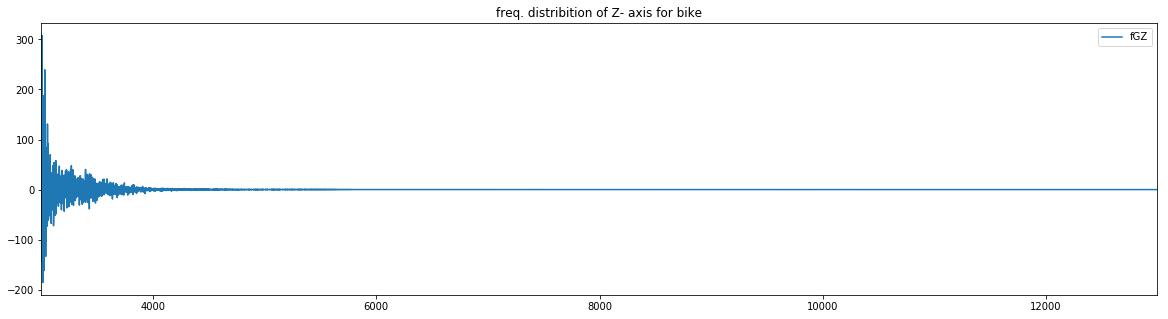

In [75]:
df_freq_car[['fGZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis for car")
df_freq_bike[['fGZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis for bike")

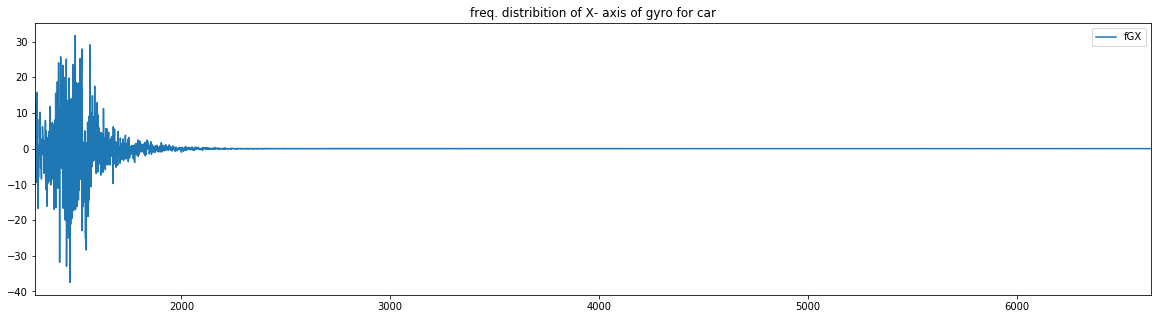

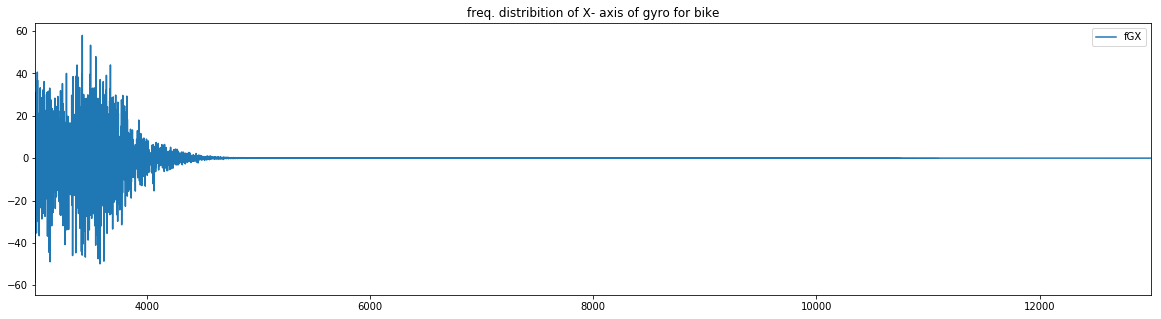

In [76]:
df_freq_car[['fGX']].plot(figsize =(20,5), title = "freq. distribition of X- axis of gyro for car")
df_freq_bike[['fGX']].plot(figsize =(20,5), title = "freq. distribition of X- axis of gyro for bike")

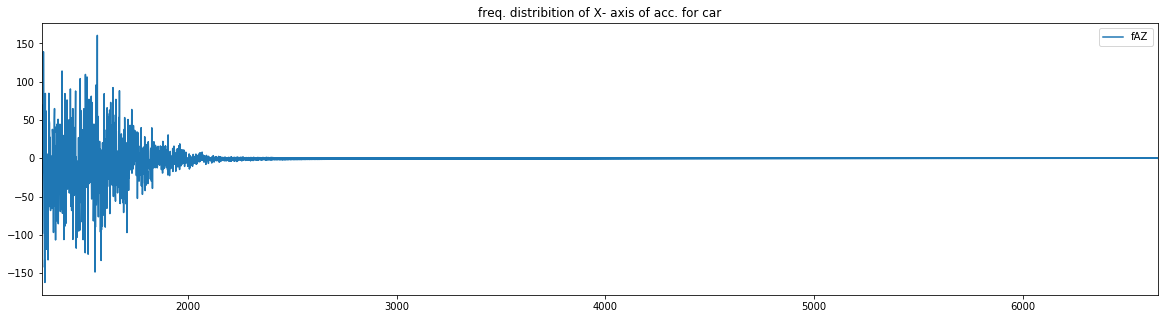

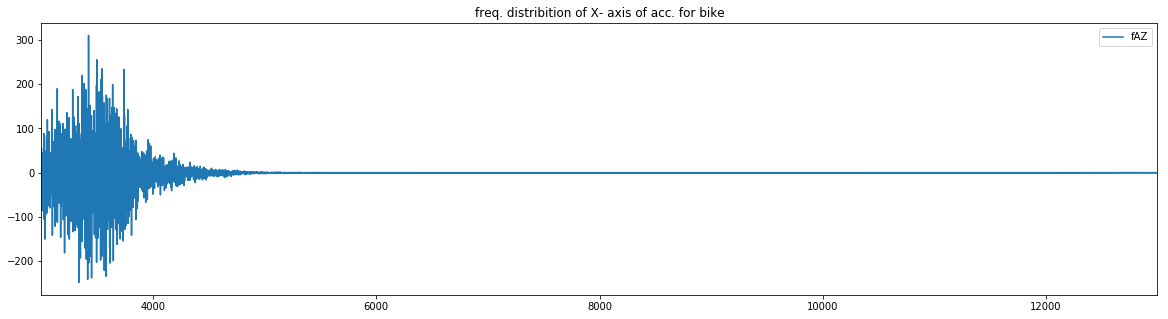

In [77]:
df_freq_car[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of X- axis of acc. for car")
df_freq_bike[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of X- axis of acc. for bike")

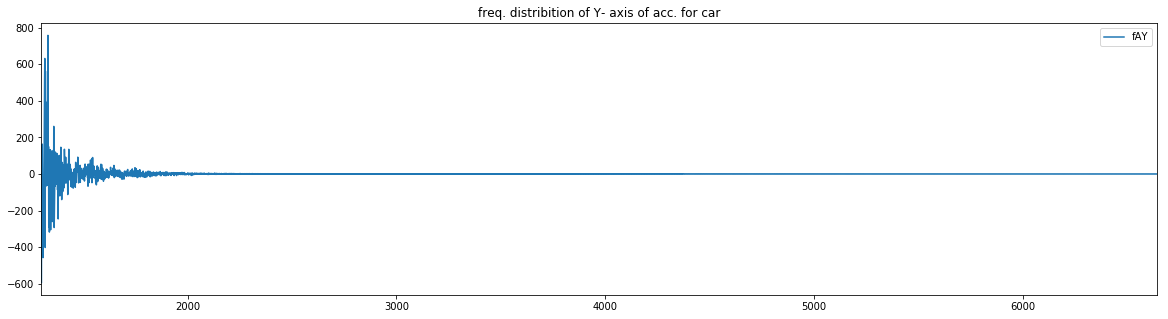

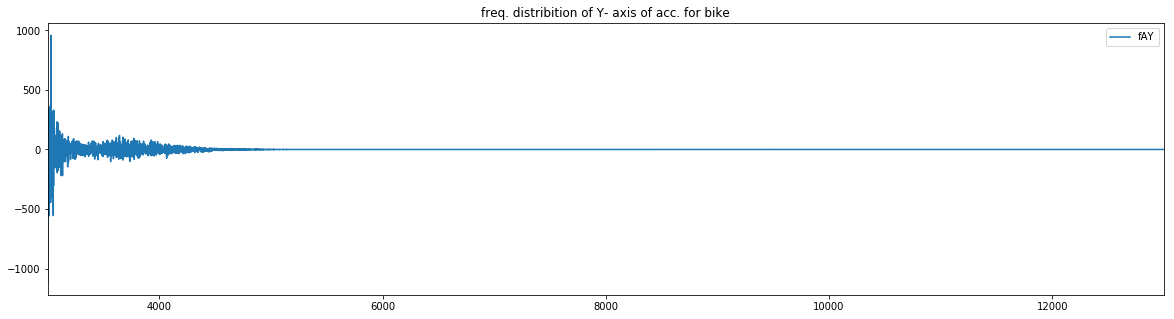

In [78]:
df_freq_car[['fAY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis of acc. for car")
df_freq_bike[['fAY']].plot(figsize =(20,5), title = "freq. distribition of Y- axis of acc. for bike")

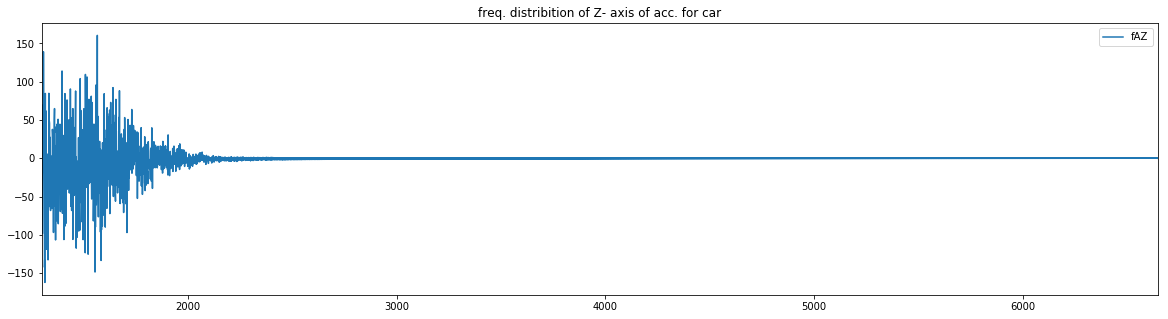

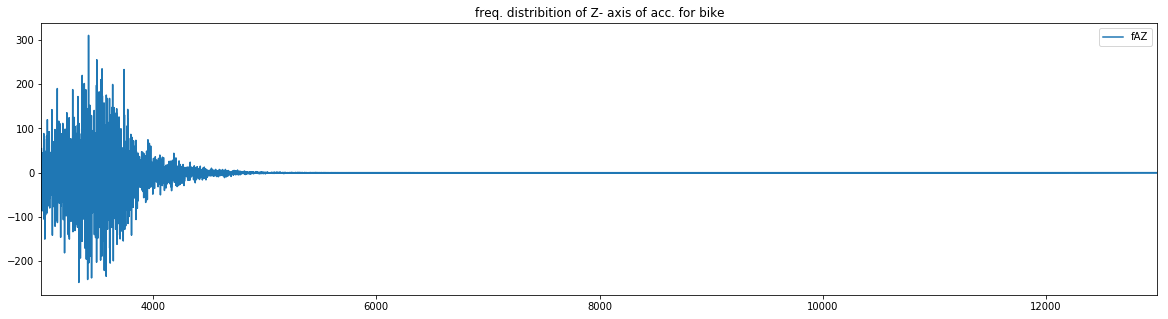

In [79]:
df_freq_car[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis of acc. for car")
df_freq_bike[['fAZ']].plot(figsize =(20,5), title = "freq. distribition of Z- axis of acc. for bike")